# base_supervised
> API needed for linear evaluation protocol, and semi-supervised learning (k-nn?) Also includes test set evaluation.

All we require here is the following: 

- an `encoder` (already pretrained)
- a training set (for fine tuning), `dls`
- possibly: a test set (for evaluation) `dls_test`
- augmentations, generally pretty standard but e.g. cifar vs mnist will be different.

The general API will involve:

- i) running learning rate finder
- ii) training using 1cycle policy and the lr found in a)

Designed to be extensible and work with any encoder.

In [ ]:
#| default_exp base_supervised

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export
import importlib
import self_supervised
import torch
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import kornia.augmentation as korniatfm
import torchvision.transforms as tvtfm
from fastai.learner import load_learner
from base_rbt.utils import *
from base_rbt.base_model import get_barlow_twins_aug_pipelines
from base_rbt.metrics import *

API:


- Train and then test linear head. Requires inputs: encoder, dls_val, augpipe_val, indim,outdim, num_epochs,

In [ ]:
#| export
#Batch level augmentations for linear classifier. At present time, just RandomResizedCrop and Normalization.
def get_linear_batch_augs(size,resize=True,
                    resize_scale=(0.08, 1.0),resize_ratio=(3/4, 4/3),
                    stats=None,cuda=default_device().type == 'cuda',xtra_tfms=[]):
    
    "Input batch augmentations implemented in tv+kornia+fastai"
    tfms = []
    if resize:tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]
    tfms += xtra_tfms
    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

The model for linear evaluation and semi-supervised learning requires an encoder and a (randomly)
initialised head.


In [ ]:
#| export

class LM(nn.Module):
    "Basic linear model"
    def __init__(self,encoder,numout,encoder_dimension=2048):
        super().__init__()
        self.encoder=encoder
        self.head=nn.Linear(encoder_dimension,numout)

    def forward(self,x):
        return self.head(self.encoder(x))

The 'callback' for linear evaluation is the following:

In [ ]:
#| export
# class LinearBt(Callback):
#     order,run_valid = 9,True
#     def __init__(self,aug_pipelines,n_in, show_batch=False, print_augs=False,data=None):
#         assert_aug_pipelines(aug_pipelines)
#         self.aug1= aug_pipelines[0]
#         self.aug2=Pipeline( split_idx = 0) #empty pipeline
#         if print_augs: print(self.aug1), print(self.aug2)
#         self.n_in=n_in
#         self._show_batch=show_batch
#         self.criterion = nn.CrossEntropyLoss()
        
#         self.data=data #if data is just e.g. 20 samples then don't bother re-loading each time
        
#     def before_fit(self): 
#         self.learn.loss_func = self.lf
            
#     def before_batch(self):

#         if self.n_in == 1:
#             xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))                            
#         elif self.n_in == 3:
#             xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
#         self.learn.xb = (xi,)

#         if self._show_batch:
#             self.learn.aug_x = torch.cat([xi, xj])

#     def lf(self, pred, *yb):        
#         loss=self.criterion(pred,self.y)
#         return loss

#     @torch.no_grad()
#     def show(self, n=1):
#         if self._show_batch==False:
#             print('Need to set show_batch=True')
#             return
#         bs = self.learn.aug_x.size(0)//2
#         x1,x2  = self.learn.aug_x[:bs], self.learn.aug_x[bs:]
#         idxs = np.random.choice(range(bs),n,False)
#         x1 = self.aug1.decode(x1[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
#         x2 = self.aug2.decode(x2[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
#         images = []
#         for i in range(n): images += [x1[i],x2[i]]
#         return show_batch(x1[0], None, images, max_n=len(images), nrows=n)


#A more comprehensive callback, copy pasted from cancer-proj
class LinearBt(Callback):
    order,run_valid = 9,True
    def __init__(self,aug_pipelines,n_in, show_batch=False, print_augs=False,data=None,
                 tune_model_path=None,tune_save_after=None):
        self.aug1= aug_pipelines[0]
        self.aug2=Pipeline( split_idx = 0) #empty pipeline
        if print_augs: print(self.aug1), print(self.aug2)
        self.n_in=n_in
        self._show_batch=show_batch
        self.criterion = nn.CrossEntropyLoss()
        self.data=data #if data is just e.g. 20 samples then don't bother re-loading each time


    def before_fit(self):
        self.learn.loss_func = self.lf
            
    def before_batch(self):

        if self.n_in == 1:
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))                            
        elif self.n_in == 3:
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
        self.learn.xb = (xi,)

        if self._show_batch:
            self.learn.aug_x = torch.cat([xi, xj])

    def lf(self, pred, *yb):        
        loss=self.criterion(pred,self.y)
        return loss

    @torch.no_grad()
    def show(self, n=1):
        if self._show_batch==False:
            print('Need to set show_batch=True')
            return
        bs = self.learn.aug_x.size(0)//2
        x1,x2  = self.learn.aug_x[:bs], self.learn.aug_x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone(),full=False).clamp(0,1) #full=True / False
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

Test:

Example usage: First inputs needed. In the next cell we get dls_val and dls_test. 

Augmentations and learner:

In [ ]:
#| export
def show_linear_batch(dls,n_in,aug,n=2,print_augs=True):
    "Given a linear learner, show a batch"
    bt = LinearBt(aug,show_batch=True,n_in=n_in,print_augs=print_augs)
    learn = Learner(dls,model=None, cbs=[bt])
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    axes = learn.linear_bt.show(n=n)
    

In [ ]:
# def get_bt_cifar10_aug_pipelines(size):
#     aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
#                                                     bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
#                                                     resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,
#                                                     bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.5, jitter_p=0.5, blur_p=0.5,sol_p=0.0,
#                                                     stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
#                                                     )

#     aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
#                                                     bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
#                                                     resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,sol_t=0.01,sol_a=0.01,
#                                                     bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.5, jitter_p=0.5, blur_p=0.1,sol_p=0.2,
#                                                     stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
#                                                     )

#     bt_cifar10_aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

#     return bt_cifar10_aug_pipelines

# #Add other augmentations here e.g. BYOL augs

# bt_aug_func_dict = {'bt_cifar10_aug_pipelines':get_bt_cifar10_aug_pipelines}


# def get_bt_aug_pipelines(bt_augs,size):

#     return bt_aug_func_dict[bt_augs](size)

In [ ]:
#| export

def get_supervised_dls(dataset,
                      pct_dataset_train,
                      pct_dataset_test,
                      bs,
                      bs_test,size,
                      device):
    "Get train and test dataloaders for supervised learning"

    try:
        # Construct the module path
        module_path = f"{PACKAGE_NAME}.{dataset}_dataloading"
        
        # Dynamically import the module
        dataloading_module = importlib.import_module(module_path)
    except ModuleNotFoundError:
        # Handle the case where the module cannot be found
        raise ImportError(f"Could not find a data loading module for '{dataset}'. "
                          f"Make sure '{module_path}' exists and is correctly named.") from None
    
    # Assuming the function name follows a consistent naming convention
    func_name_train = f"get_supervised_{dataset}_train_dls"
    try:
        # Retrieve the data loading function from the module
        train_data_loader_func = getattr(dataloading_module, func_name_train)
    except AttributeError:
        # Handle the case where the function does not exist in the module
        raise AttributeError(f"The function '{func_name_train}' was not found in '{module_path}'. "
                             "Ensure it is defined and named correctly.") from None
    
    # Proceed to call the function with arguments from the config
    try:
        dls_train = train_data_loader_func(bs=bs,
                                           size=size,
                                           pct_dataset=pct_dataset_train,
                                           device=device
                                            )
    except Exception as e:
        # Handle any errors that occur during the function call
        raise RuntimeError(f"An error occurred while calling '{func_name_train}' from '{module_path}': {e}") from None
    
    
      # Assuming the function name follows a consistent naming convention
    func_name_test = f"get_supervised_{dataset}_test_dls"
    try:
        # Retrieve the data loading function from the module
        test_data_loader_func = getattr(dataloading_module, func_name_test)
    except AttributeError:
        # Handle the case where the function does not exist in the module
        raise AttributeError(f"The function '{func_name_test}' was not found in '{module_path}'. "
                             "Ensure it is defined and named correctly.") from None
    
    # Proceed to call the function with arguments from the config
    try:
        dls_test = test_data_loader_func(bs=bs_test,
                                         size=size,
                                         pct_dataset=pct_dataset_test,
                                         device=device
                                        )
    except Exception as e:
        # Handle any errors that occur during the function call
        raise RuntimeError(f"An error occurred while calling '{func_name_test}' from '{module_path}': {e}") from None
    
    
    return {'dls_train':dls_train,'dls_test':dls_test}

In [ ]:
#| export


def get_supervised_cifar10_augmentations(size):

    return get_linear_batch_augs(size=size,resize=True,resize_scale=(0.3,1.0),stats=cifar_stats)


def get_supervised_isic_augmentations(size):

    aug_pipelines_tune =  [get_barlow_twins_aug_pipelines(size=size,
                    rotate=True,jitter=False,noise=False,bw=False,blur=False,solar=False,cutout=False, #Whether to use aug or not
                    resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),rotate_deg=45.0,
                    flip_p=0.25, rotate_p=0.25,
                    same_on_batch=False,stats=None
                                                         )
                           ]
    return aug_pipelines_tune


def get_supervised_aug_pipelines(augs,size):

    return supervised_aug_func_dict[augs](size)


supervised_aug_func_dict = {'supervised_cifar10_augmentations':get_supervised_cifar10_augmentations,
                            'supervised_isic_augmentations':get_supervised_isic_augmentations}

Test:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: 


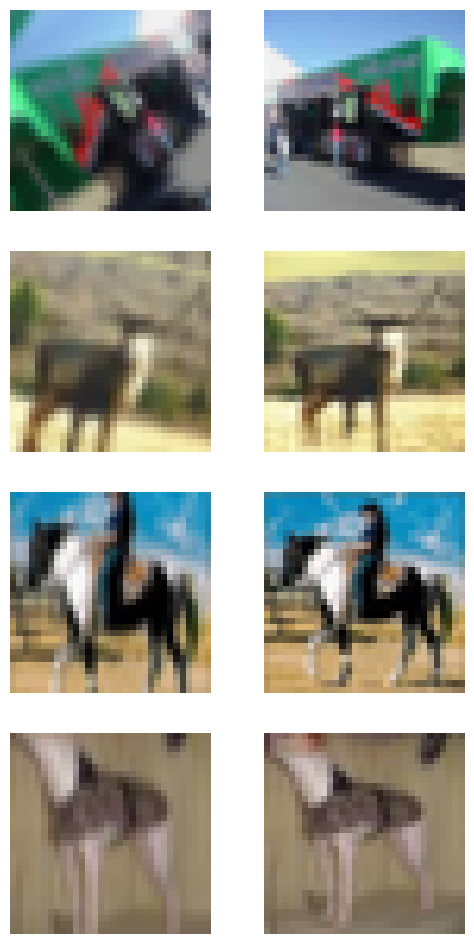

In [ ]:
#| hide

dls_dict = get_supervised_dls(dataset='cifar10',
    pct_dataset_train=0.1,
    pct_dataset_test=0.1,
    bs=64,
    bs_test=64,
    size=32,
    device='cpu')

dls_train = dls_dict['dls_train']


supervised_augmentations = get_supervised_aug_pipelines('supervised_isic_augmentations',size=32)
show_linear_batch(dls_train, n_in=3, aug=supervised_augmentations,n=4, print_augs=True)


This enables us to freeze the encoder as needed:

In [ ]:
#| export
def encoder_head_splitter(m):
    return L(sequential(*m.encoder),m.head).map(params)

`SupervisedLearning` allows us to perform either linear evaluation, semi-supervised learning, or standard supervised learning.

In [ ]:
#| export
class SaveSupLearnerModel(Callback):
    def __init__(self, experiment_dir,num_run):
        self.experiment_dir = experiment_dir
        self.num_run = num_run
    def after_fit(self):
        model_filename = f"trained_model_num_run_{self.num_run}.pth"
        model_path = os.path.join(self.experiment_dir, model_filename)
        torch.save(self.learn.model.state_dict(), model_path)
        print(f"Model state dict saved to {model_path}")



In [ ]:
#| export

class SupervisedLearning:
    "Train model using supervised learning. Either linear evaluation or semi-supervised."

    def __init__(self,
                 model,
                 dls_train,
                 aug_pipelines_supervised,
                 n_in,
                 wd,
                 device,
                 num_it=100,
                 num_run=None, #n of num_runs. e.g. num_runs=5 and num_run=3 means this is the 3rd run. 
                               #Basically just tells what name to save checkpoint as - if applicable.
                 experiment_dir=None,
                 ):

             
       
        store_attr()
        self.learn = self.setup_learn()

    
    def setup_learn(self):
        """
        Sets up the learner with the model, callbacks, and metrics.

        Returns:
        - learn: The Learner object.
        """
        # Setup the model: encoder + head
        #model = LM(encoder=self.encoder, enc_dim=self.enc_dim, numout=len(self.dls_train.vocab))
        self.model.to(self.device)

        cbs = [LinearBt(aug_pipelines=self.aug_pipelines_supervised, show_batch=True, n_in=self.n_in, print_augs=True)]

        # Setup the learner with callbacks and metrics
        learn = Learner(self.dls_train, self.model, splitter=encoder_head_splitter,cbs=cbs,wd=self.wd, metrics=accuracy)

        return learn
    
    def _get_training_cbs(self):
        "Add train-time cbs to learner. Note e.g. we don't want these in operation when we're doing lr_find."

        #NOTE:
        cbs=[] #can add more here if needed.
        if self.experiment_dir:
            cbs.append(SaveSupLearnerModel(experiment_dir=self.experiment_dir,
                                                num_run = self.num_run,
                                            )
                        )
            
        return cbs
    
    def supervised_learning(self,epochs:int=1):

        test_grad_on(self.learn.model.encoder)
        test_grad_on(self.learn.model.head)
        lrs = self.learn.lr_find(num_it=self.num_it)
        self.learn.fit_one_cycle(epochs, lrs.valley,cbs=self._get_training_cbs())
        return self.learn
    
    def linear_evaluation(self,epochs:int=1):

        self.learn.freeze() #freeze encoder
        test_grad_off(self.learn.model.encoder)
        lrs = self.learn.lr_find(num_it=self.num_it) #find learning rate
        self.learn.fit_one_cycle(epochs, lrs.valley,cbs=self._get_training_cbs()) #fit head
        return self.learn

    def semi_supervised(self,freeze_epochs:int=1,epochs:int=1):

        self.learn.freeze() #freeze encoder
        test_grad_off(self.learn.model.encoder)
        self.learn.fit(freeze_epochs) #fit head for (typically one) epoch
        self.learn.unfreeze() #unfreeze encoder
        test_grad_on(self.learn.model)
        lrs = self.learn.lr_find(num_it=self.num_it) #find learning rate
        self.learn.fit_one_cycle(epochs, lrs.valley,cbs=self._get_training_cbs())
        return self.learn
    
    def train(self,learn_type, freeze_epochs:int,epochs:int):

        if learn_type == 'standard':
            return self.supervised_learning(epochs=epochs)

        elif learn_type == 'linear_evaluation':
            return self.linear_evaluation(epochs=epochs)

        elif learn_type == 'semi_supervised':
            return self.semi_supervised(freeze_epochs=freeze_epochs,epochs=epochs)

        else: raise Exception("Invalid weight_type")




In [ ]:
#| export
def get_encoder(arch,weight_type,load_pretrained_path=None):
    "Get an encoder for supervised learner. If load_pretrained_path is not None, load the weights from that path."

    encoder = resnet_arch_to_encoder(arch,weight_type)
    if not load_pretrained_path:

        return encoder

    else:

        encoder.load_state_dict(torch.load(load_pretrained_path))
        
        return encoder                          

In [ ]:
#| export

def load_sup_model(config,numout,path):

    #Setup model with random weights
    encoder = get_encoder(arch=config.arch,weight_type='random',load_pretrained_path=None)
    model = LM(encoder=encoder, numout=numout, encoder_dimension=config.encoder_dimension)
    
    #load model
    model.load_state_dict(torch.load(path))


In [ ]:
#| export

def save_metrics(model, #trained model
                 aug_pipelines_supervised,
                 experiment_dir, #where to save
                 num_run, #how to name metrics files 
                 dls_train, #just used to compute vocab
                 dls_test, #test set
                 ):
    
        #Save this in experiment_dir also
    classes_to_int={v:i for i,v in enumerate(dls_train.vocab)}
    int_to_classes = {i: v for i, v in enumerate(dls_train.vocab)}
    vocab=dls_train.vocab    

    metrics = get_dls_metrics(dls_test,model,aug_pipelines_supervised,int_to_classes)
    metrics['classes_to_int'] = classes_to_int
    metrics['int_to_classes'] = int_to_classes
    metrics['vocab'] = vocab

    if experiment_dir:
        save_dict_to_gdrive(metrics, experiment_dir, f'metrics_num_run_{num_run}')

    return metrics

In [ ]:
#| export
def main_sup_train(config,
        num_run=None,#run we are up to - tell us what name to give the saved checkpoint, if applicable.
        train=True, #if False, load model and compute and save metrics only
        experiment_dir=None, #where to save checkpoints
        ):
    
    """Basically map from config to training a supervised model. Optionally save checkpoints of learner.
        Also compute metrics on test set and save. If train is `False` load model according to num_run (means
        it already exists) and just compute metrics
    """

    if 'pretrained' in config.weight_type:
        test_eq(config.learn_type in ['semi_supervised','linear_evaluation'],True)

    if config.weight_type == 'dermnet_bt_pretrained':
        print(f"For weight_type={config.weight_type}, make sure you have the correct path. The path to load pretrained encoder we are using is: {config.load_pretrained_path}")


    # #cuda or cpu
    device = default_device()

    dls_dict = get_supervised_dls(dataset=config.dataset,
                                  pct_dataset_train=config.pct_dataset_train,
                                  pct_dataset_test=config.pct_dataset_test,
                                  bs=config.bs, 
                                  bs_test=config.bs_test, 
                                  size=config.size, 
                                  device=device)


    dls_train = dls_dict['dls_train']
    dls_test = dls_dict['dls_test']

    aug_pipelines_supervised = get_supervised_aug_pipelines(config.sup_augs, size=config.size)

    #get encoder: e.g. via loading from checkpoint, or a pretrained model

    #get model: e.g. via loading from checkpoint, or a pretrained model

    numout = len(dls_train.vocab)
    encoder = get_encoder(arch=config.arch,weight_type=config.weight_type,load_pretrained_path=config.load_pretrained_path)
    model = LM(encoder=encoder, numout=numout, encoder_dimension=config.encoder_dimension)


    supervised_trainer = SupervisedLearning(model=model,
                            dls_train=dls_train,
                            aug_pipelines_supervised=aug_pipelines_supervised,
                            n_in=config.n_in,
                            wd=config.wd,
                            device=device,
                            num_it=config.num_it,
                            num_run=num_run,
                            experiment_dir=experiment_dir,
                            )

    # Train the model with the specified configurations and save `learn` checkpoints
    if train: 
        learn = supervised_trainer.train(learn_type=config.learn_type,freeze_epochs=config.freeze_epochs,epochs=config.epochs)
        model = learn.model
    else:
        print(f"train is {train}. Loading model from {experiment_dir}.")
        learn=None
        path = os.path.join(experiment_dir, f"trained_model_num_run_{num_run}.pth")
        load_sup_model(config,numout,path) #load state_dict
        model.to(device)
    
    metrics = save_metrics(model, aug_pipelines_supervised, experiment_dir, num_run, dls_train, dls_test)      
    
    #metrics = load_dict_from_gdrive(experiment_dir, 'metrics')

    return learn,metrics

    


Actually don't think we need this.

In [ ]:
#| export 

def get_largest_metric_file(experiment_dir):
    metric_files = [f for f in os.listdir(experiment_dir) if 'metrics' in f]
    
    if not metric_files:
        return None,None
    
    max_num = -1
    max_file = ''
    
    for file in metric_files:
        match = re.search(r'_(\d+)\.pkl$', file)
        if match:
            num = int(match.group(1))
            if num > max_num:
                max_num = num
                max_file = file
    
    num = max_file.split('.pkl')[0].split('_')[-1]
    return max_file,num

In [ ]:
#| hide
with tempfile.TemporaryDirectory() as dir:

    save_dict_to_gdrive({'a':1}, dir, 'metrics_num_run_1')
    save_dict_to_gdrive({'a':2}, dir, 'metrics_num_run_2')
    save_dict_to_gdrive({'a':4}, dir, 'metrics_num_run_4')

    print(os.listdir(dir))

    max_file,num = get_largest_metric_file(dir)

    test_eq(max_file,'metrics_num_run_4.pkl')
    test_eq(num,'4')



['metrics_num_run_1.pkl', 'metrics_num_run_2.pkl', 'metrics_num_run_4.pkl']


In [ ]:
#| export

def get_supervised_experiment_state(config,base_dir,experiment_dir):
    """Get the load_learner_path, num_run, for supervised experiment.
       Basically tells us what run we are up to. `load_learner_path` is the path to the highest numbered checkpoint.
       so far. `num_run` is the number of the next run. If num_run>config.num_runs, then we are done.

       We also have to find out what results computation we are up. e.g. we may have finished training for 
       a given num_run but not computed the metrics
    """


    load_learner_path, _  = get_highest_num_path(base_dir, config) #we construct experiment_dir in `get_highest_num_path` as well
                                                                    #but also happen to need it for `metric_list` calculation.
    
    #Note that if 
    num_run=1 if load_learner_path is None else int(load_learner_path.split('_')[-1])+1

    if num_run>config.num_runs:
        print(f"num_run={num_run}, but already completed {config.num_runs} runs. Exiting.")
        sys.exit()
    

    return load_learner_path, num_run

In [ ]:
#| export
def main_sup_experiment(config,
                        base_dir,
                       ):
        """Run a supervised learning experiment with the given configuration and save the results to the experiment directory. Return the experiment directory and experiment hash.
        """
        experiment_dir,experiment_hash,git_commit_hash = setup_experiment(config,base_dir)

        #This time, we don't want to resume but we want to determine which experiment we're running.
        #i.e. for each config, we will train several models.
        #TODO:

        #repeatedly train models until we have done config.num_runs runs. Possibly picking up where we left off.
        num_run=0
        while num_run<config.num_runs:
            _, num_run = get_supervised_experiment_state(config,base_dir,experiment_dir)
            main_sup_train(config=config,
                        num_run=num_run,#run we are up to - tell us what name to give the saved checkpoint, if applicable.
                        train=True,
                        experiment_dir=experiment_dir,
                        )
            
        #Possibly we haven't computed metrics for all models yet, e.g. if the session crashed.
        #We can just compute metrics for all models now, unless it's already been done
    

    
        #We need to have completed all runs to get this metric
        all_metrics={}
        for num_run in range(1,config.num_runs+1):

            print(f"num_run is {num_run}")
            try: 
                metrics = load_dict_from_gdrive(experiment_dir, f'metrics_num_run_{num_run}')
            
            #Possible we have saved the model but not computed metrics yet, in case
            #e.g. colab exited in the middle of the calculation.
            except FileNotFoundError:
                print(f"metrics_num_run_{num_run} not found. Computing now:")
                
                _,metrics = main_sup_train(config=config,
                        num_run=num_run,#run we are up to - tell us what name to give the saved checkpoint, if applicable.
                        train=False,
                        experiment_dir=experiment_dir,
                                        )
            
            all_metrics[num_run]=metrics

            print(f"num_run={num_run},acc={metrics['acc']}, metrics={metrics}")

    
        vocab = metrics['vocab']
        mean_results = Mean_Results(all_metrics,vocab)

        save_dict_to_gdrive(mean_results, experiment_dir, 'mean_results')


        # Save a metadata file in the experiment directory with the Git commit hash and other details
        save_metadata_file(experiment_dir=experiment_dir, git_commit_hash=git_commit_hash)

        # After experiment execution and all processing are complete
        update_experiment_index(base_dir,{
        "experiment_hash": experiment_hash,  # Unique identifier derived from the experiment's configuration
        "experiment_dir": experiment_dir,  # Absolute path to the experiment's dedicated directory
        "git_commit_hash": git_commit_hash,  # Git commit hash for the code version used in the experiment
        # Potentially include additional details collected during or after the experiment, such as:
        # Any other metadata or results summary that is relevant to the experiment
                        })

        return experiment_dir,experiment_hash,num_run #Return the experiment_dir so we can easily access the results of the experiment


Full example

dataset: cifar10
arch: smallres
train_type: supervised
weight_type: random
learn_type: standard
size: 32
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_cifar10_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 10
pct_dataset_train: 0.01
pct_dataset_test: 0.1
epochs: 1
num_runs: 2
load_pretrained_path: None
encoder_dimension: 512
The experiment_dir is: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpd1lvjdjr/supervised/cifar10/smallres/58adecf5 and the experiment hash is: 58adecf5
Configuration saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpd1lvjdjr/supervised/cifar10/smallres/58adecf5/config.yaml
The git hash is: 9983e8f2f1c57130221959e3f37660c18bdab11f
Looking in /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpd1lvjdjr/supervised/cifar10/smallres/58adecf5 for highest num saved


RandomResizedCrop:
encodes: (object,object) -> RandomResizedCropdecodes: 
Pipeline: 


/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,accuracy,time
0,2.297464,None,None,00:04


Model state dict saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpd1lvjdjr/supervised/cifar10/smallres/58adecf5/trained_model_num_run_1.pth


/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

    airplane       1.00      0.27      0.43       148
  automobile       0.00      0.00      0.00        92
        bird       0.00      0.00      0.00        93
         cat       0.00      0.00      0.00        86
        deer       0.00      0.00      0.00       114
         dog       0.00      0.00      0.00       100
        frog       0.00      0.00      0.00        94
       horse       0.10      1.00      0.19        98
        ship       0.00      0.00      0.00        77
       truck       0.00      0.00      0.00        98

    accuracy                           0.14      1000
   macro avg       0.11      0.13      0.06      1000
weighted avg       0.16      0.14      0.08      1000

auc_dict is: {'airplane': 0.23325085649029315, 'automobile': 0.44010965332311813, 'bird': 0.4437647449348555, 'cat': 0.554469238206707, 'deer': 0.4871292226050453, 'dog': 0.4626888888888889, 'frog': 0.6370649570240947, 'horse': 0.43814199737

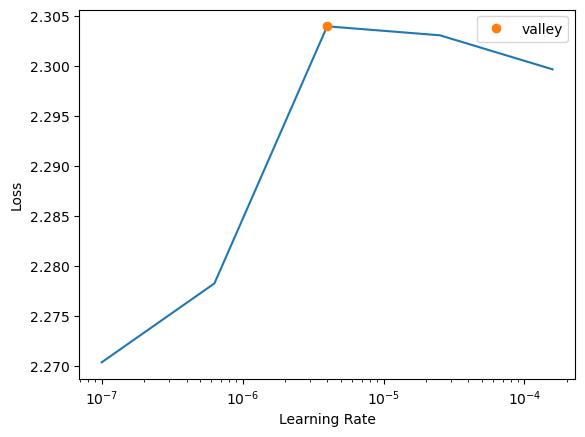

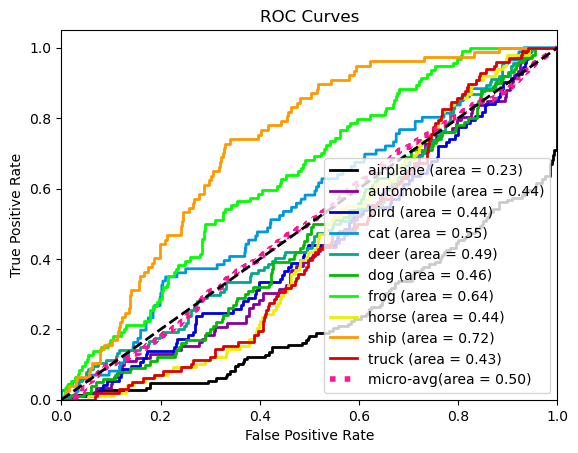

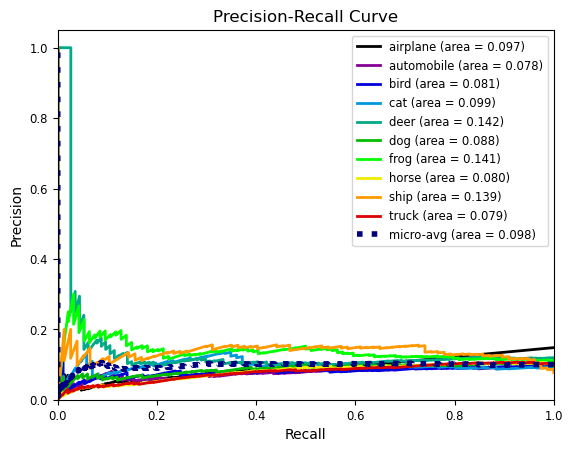

auc_dict is: {'airplane': 0.09713286097533752, 'automobile': 0.0778626170707557, 'bird': 0.0807253474222743, 'cat': 0.09897957128266063, 'deer': 0.14168182601941987, 'dog': 0.08824097378213694, 'frog': 0.1413817232601587, 'horse': 0.0799249921440117, 'ship': 0.13935584408460366, 'truck': 0.07878799347298346}
Looking in /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpd1lvjdjr/supervised/cifar10/smallres/58adecf5 for highest num saved
Found max file path: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpd1lvjdjr/supervised/cifar10/smallres/58adecf5/trained_model_num_run_1.pth and max experiment dir: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpd1lvjdjr/supervised/cifar10/smallres/58adecf5
RandomResizedCrop:
encodes: (object,object) -> RandomResizedCropdecodes: 
Pipeline: 


/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,accuracy,time
0,2.348101,None,None,00:02


Model state dict saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpd1lvjdjr/supervised/cifar10/smallres/58adecf5/trained_model_num_run_2.pth


/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

    airplane       1.00      0.31      0.48       128
  automobile       0.00      0.00      0.00        98
        bird       0.00      0.00      0.00        95
         cat       0.00      0.00      0.00        95
        deer       0.00      0.00      0.00       102
         dog       0.06      0.12      0.08        82
        frog       0.00      0.00      0.00        99
       horse       0.00      0.00      0.00        96
        ship       0.00      0.00      0.00       105
       truck       0.11      0.89      0.20       100

    accuracy                           0.14      1000
   macro avg       0.12      0.13      0.08      1000
weighted avg       0.14      0.14      0.09      1000

auc_dict is: {'airplane': 0.5544814363532111, 'automobile': 0.4538214398841577, 'bird': 0.5876708345449257, 'cat': 0.4654085489968014, 'deer': 0.3184418533560418, 'dog': 0.5669668951591477, 'frog': 0.6251359320171751, 'horse': 0.485077894542

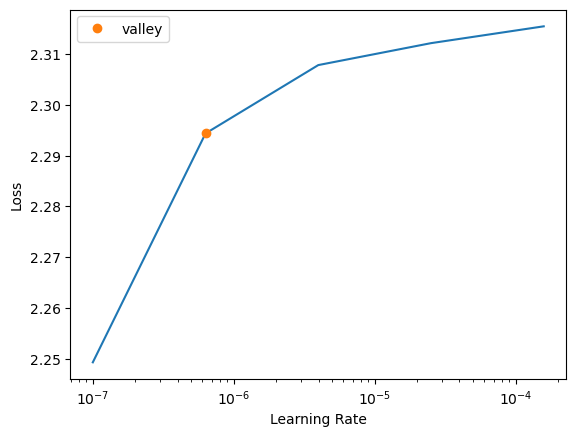

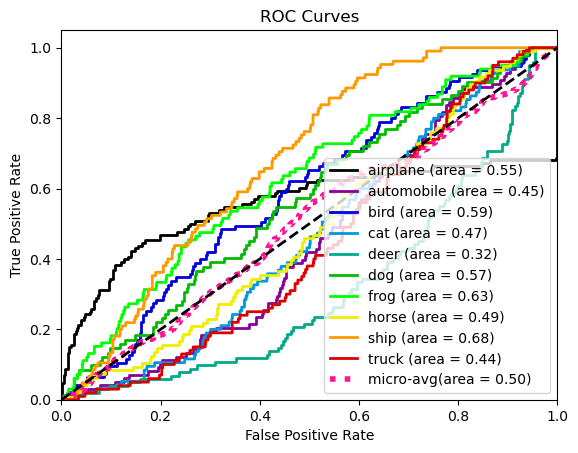

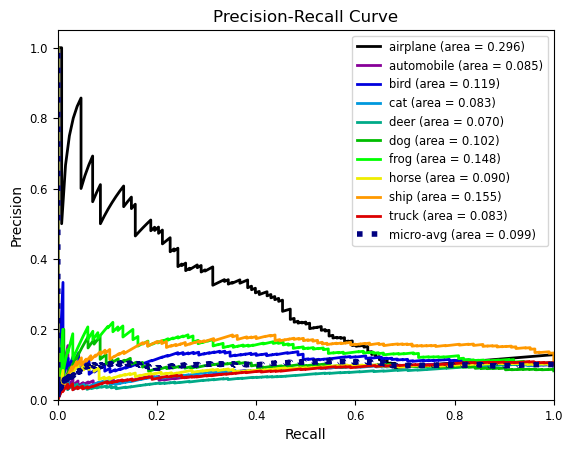

auc_dict is: {'airplane': 0.29614133350985167, 'automobile': 0.08525452154689547, 'bird': 0.11855660209152633, 'cat': 0.08279325763663437, 'deer': 0.07021044441177043, 'dog': 0.10203997422919925, 'frog': 0.1480118325839568, 'horse': 0.0902640850633787, 'ship': 0.15489552344956217, 'truck': 0.08257770344745083}
num_run is 1
num_run=1,acc=0.1379999965429306, metrics={'airplane': {'precision': 1.0, 'recall': 0.2702702702702703, 'f1-score': 0.4255319148936171, 'support': 148}, 'automobile': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 92}, 'bird': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 93}, 'cat': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 86}, 'deer': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 114}, 'dog': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 100}, 'frog': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 94}, 'horse': {'precision': 0.10261780104712041, 'recall': 1.0, 'f1-sco

In [ ]:
# #| hide
with tempfile.TemporaryDirectory() as base_dir:
    
    config_path = '../configs/cifar10/sup_test_config.yaml'
    
    config = load_config(config_path)

    pretty_print_ns(config)

    experiment_dir,experiment_hash,num_run = main_sup_experiment(config,base_dir)
    
    print(os.listdir(experiment_dir))
    print(os.listdir(base_dir))
    print('experiment_dir and base_dir') 
    



dataset: cifar10
arch: smallres
train_type: supervised
weight_type: random
learn_type: standard
size: 32
n_in: 3
bs: 64
bs_test: 64
sup_augs: supervised_cifar10_augmentations
wd: 0.0
freeze_epochs: 1
num_it: 10
pct_dataset_train: 0.01
pct_dataset_test: 0.1
epochs: 1
num_runs: 2
load_pretrained_path: None
encoder_dimension: 512
base_dir is: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpjyn2apf0
The experiment_dir is: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpjyn2apf0/supervised/cifar10/smallres/58adecf5 and the experiment hash is: 58adecf5
Configuration saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpjyn2apf0/supervised/cifar10/smallres/58adecf5/config.yaml
The git hash is: 9983e8f2f1c57130221959e3f37660c18bdab11f
Looking in /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpjyn2apf0/supervised/cifar10/smallres/58adecf5 for highest num saved
RandomResizedCrop:
encodes: (object,object) -> RandomResizedCropdecodes: 
Pipeline: 


/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,accuracy,time
0,2.328104,None,None,00:02


Model state dict saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpjyn2apf0/supervised/cifar10/smallres/58adecf5/trained_model_num_run_1.pth


/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

    airplane       0.27      0.52      0.35       144
  automobile       0.00      0.00      0.00        95
        bird       0.00      0.00      0.00        92
         cat       0.00      0.00      0.00       101
        deer       0.12      0.90      0.22        96
         dog       0.00      0.00      0.00        87
        frog       0.00      0.00      0.00        96
       horse       0.00      0.00      0.00        86
        ship       0.00      0.00      0.00        98
       truck       0.00      0.00      0.00       105

    accuracy                           0.16      1000
   macro avg       0.04      0.14      0.06      1000
weighted avg       0.05      0.16      0.07      1000

auc_dict is: {'airplane': 0.4084241952232606, 'automobile': 0.5762838034312301, 'bird': 0.5048601800421375, 'cat': 0.5499179506382229, 'deer': 0.7502419800884955, 'dog': 0.5140939935289749, 'frog': 0.3926818307522124, 'horse': 0.569977354841

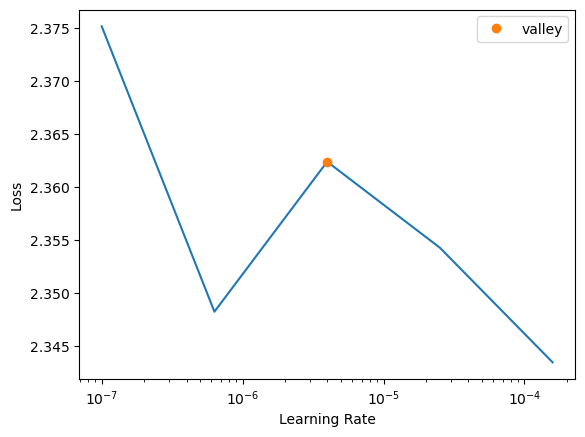

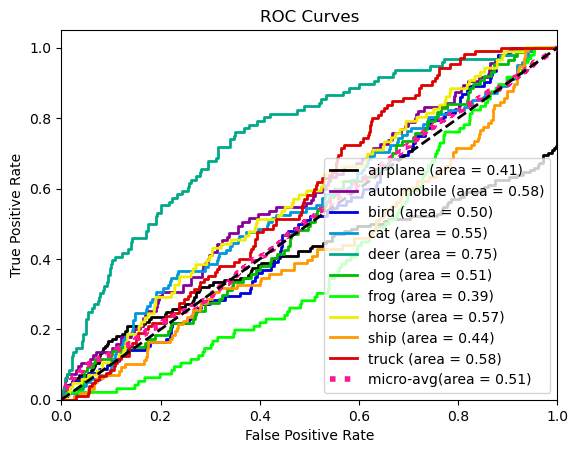

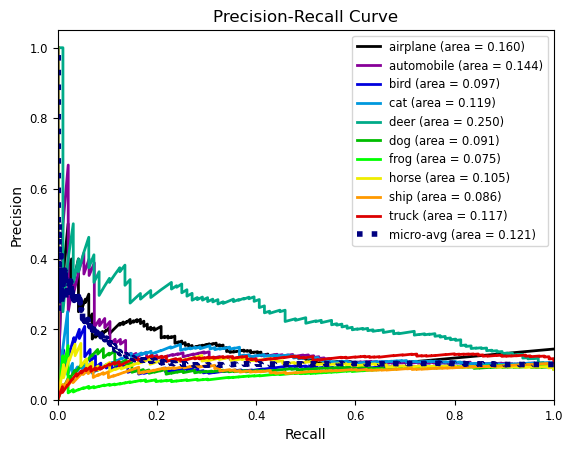

auc_dict is: {'airplane': 0.15960140728849342, 'automobile': 0.144338463869854, 'bird': 0.09734901813493559, 'cat': 0.11932264083119601, 'deer': 0.25033878111386115, 'dog': 0.09129464154068251, 'frog': 0.07528639242108234, 'horse': 0.10471347616732961, 'ship': 0.08612792172454328, 'truck': 0.11707459155553872}
Looking in /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpjyn2apf0/supervised/cifar10/smallres/58adecf5 for highest num saved
Found max file path: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpjyn2apf0/supervised/cifar10/smallres/58adecf5/trained_model_num_run_1.pth and max experiment dir: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpjyn2apf0/supervised/cifar10/smallres/58adecf5
RandomResizedCrop:
encodes: (object,object) -> RandomResizedCropdecodes: 
Pipeline: 


/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,accuracy,time
0,2.352607,None,None,00:07


Model state dict saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpjyn2apf0/supervised/cifar10/smallres/58adecf5/trained_model_num_run_2.pth


/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

    airplane       1.00      0.26      0.42       151
  automobile       0.00      0.00      0.00        88
        bird       0.15      0.29      0.20        97
         cat       0.00      0.00      0.00        96
        deer       0.00      0.00      0.00        94
         dog       0.09      0.78      0.16        86
        frog       0.00      0.00      0.00        88
       horse       0.00      0.00      0.00        87
        ship       0.00      0.00      0.00       100
       truck       0.00      0.00      0.00       113

    accuracy                           0.14      1000
   macro avg       0.12      0.13      0.08      1000
weighted avg       0.17      0.14      0.10      1000

auc_dict is: {'airplane': 0.4899102177084065, 'automobile': 0.40770783492822965, 'bird': 0.4839538308730349, 'cat': 0.49502212389380534, 'deer': 0.2722159597952187, 'dog': 0.42065289298254543, 'frog': 0.7868321371610845, 'horse': 0.577167604

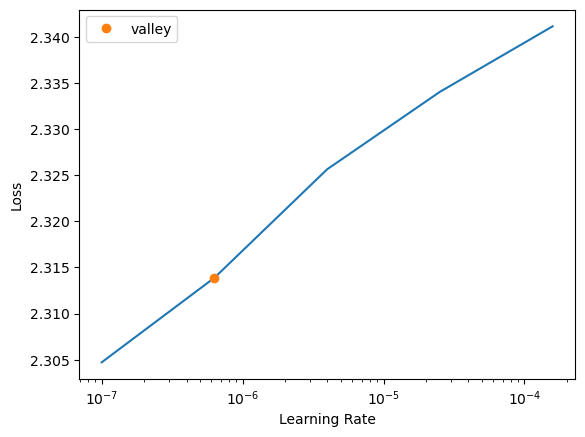

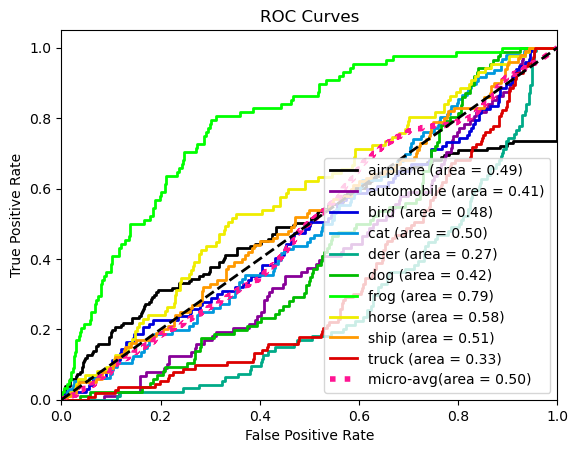

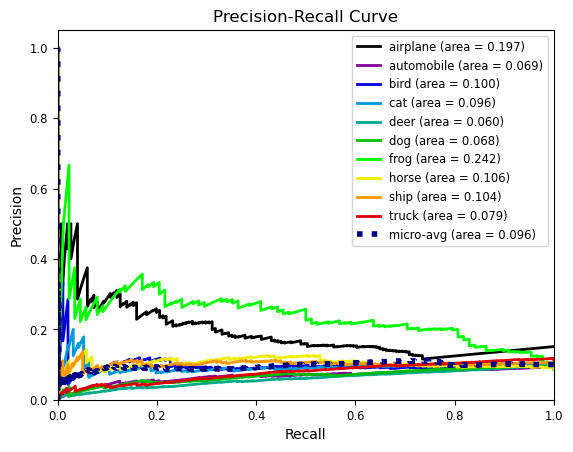

auc_dict is: {'airplane': 0.197138150550257, 'automobile': 0.068894628834479, 'bird': 0.1000714213748678, 'cat': 0.09636581200046157, 'deer': 0.06020116429901944, 'dog': 0.06845264873576715, 'frog': 0.24248478884544422, 'horse': 0.10641942796284341, 'ship': 0.10417617487838558, 'truck': 0.07865186195963908}
num_run is 1
num_run=1,acc=0.16099999845027924, metrics={'airplane': {'precision': 0.26501766784452296, 'recall': 0.5208333333333334, 'f1-score': 0.351288056206089, 'support': 144}, 'automobile': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 95}, 'bird': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 92}, 'cat': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 101}, 'deer': {'precision': 0.1225071225071225, 'recall': 0.8958333333333334, 'f1-score': 0.2155388471177945, 'support': 96}, 'dog': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 87}, 'frog': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 96}, 'horse': 

/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

              precision    recall  f1-score   support

    airplane       1.00      0.31      0.47       130
  automobile       0.50      0.01      0.02        85
        bird       0.00      0.00      0.00       105
         cat       0.00      0.00      0.00        95
        deer       0.00      0.00      0.00        95
         dog       0.00      0.00      0.00        97
        frog       0.10      1.00      0.18        92
       horse       0.00      0.00      0.00       103
        ship       0.00      0.00      0.00       102
       truck       0.00      0.00      0.00        96

    accuracy                           0.13      1000
   macro avg       0.16      0.13      0.07      1000
weighted avg       0.18      0.13      0.08      1000

auc_dict is: {'airplane': 0.34431476569407604, 'automobile': 0.4656509161041466, 'bird': 0.5902154828411812, 'cat': 0.38495492875836, 'deer': 0.7128932829310847, 'dog': 0.4997431242935918, 'frog': 0.39636803294388046, 'horse': 0.459081512268

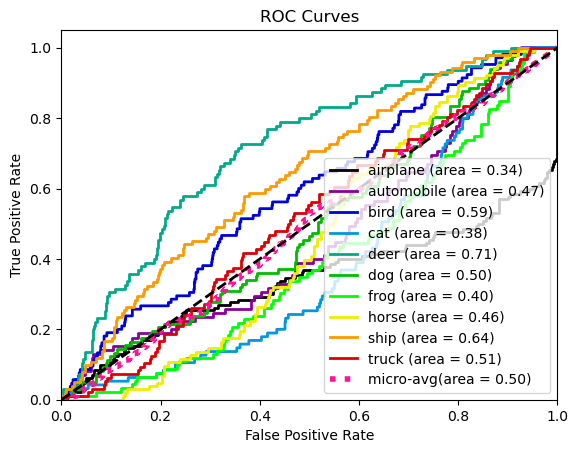

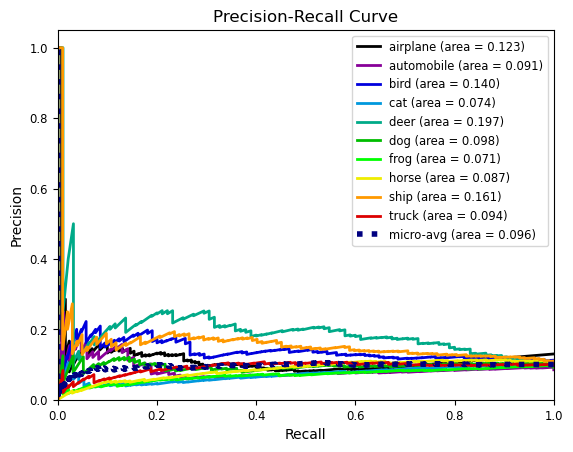

auc_dict is: {'airplane': 0.12315551177166073, 'automobile': 0.09050580024791302, 'bird': 0.13969090982214682, 'cat': 0.07409523011100802, 'deer': 0.19681615109814965, 'dog': 0.09840483962597951, 'frog': 0.07087250287640198, 'horse': 0.0869381122236209, 'ship': 0.16119052245069354, 'truck': 0.09425469882484776}
Experiment directory and base directory contain the expected files.


In [ ]:
#| hide
with tempfile.TemporaryDirectory() as base_dir:
    config_path = '../configs/cifar10/sup_test_config.yaml'
    config = load_config(config_path)
    pretty_print_ns(config)

    print(f"base_dir is: {base_dir}")
    
    experiment_dir, experiment_hash, num_run = main_sup_experiment(config, base_dir)

    # Assert that the experiment directory contains the expected files
    expected_files = [
        "trained_model_num_run_1.pth",
        "metrics_num_run_1.pkl",
        "mean_results.pkl",
        "metadata.yaml",
        "config.yaml",
                ]
    for file in expected_files:
        assert file in os.listdir(experiment_dir), f"Expected file '{file}' not found in experiment directory."

    # Test the computation of metrics when the model exists but the metrics don't
    os.remove(os.path.join(experiment_dir, "metrics_num_run_1.pkl"))
    _, metrics = main_sup_train(config=config, num_run=1, train=False, experiment_dir=experiment_dir)

    # Assert that the metrics are computed and saved correctly
    assert "metrics_num_run_1.pkl" in os.listdir(experiment_dir), "Metrics file not found after computation."
    assert metrics is not None, "Metrics not returned by main_sup_train when train=False."

    print('Experiment directory and base directory contain the expected files.')

In [ ]:
#| export

def main_fine_tune_isic(config,base_dir):
    "Just call `main_sup_experiment` for each different `pct_dataset_train` value and for given config"

    print('base config is:\n')
    pretty_print_ns(config)
    print('\n')
    for pct_dataset_train in [1.0,0.5,0.25]:
    
        config.pct_dataset_train = pct_dataset_train

        if config.pct_dataset_train==0.5:
            config.freeze_epochs=2
            config.num_run=5
        elif config.pct_dataset_train==0.25:
            config.freeze_epochs=4
            config.num_run=5
        
        print('fine tuning with config:\n')
        pretty_print_ns(config)
        main_sup_experiment(config,base_dir)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()